This notebook takes raw sensor data, identifies putts, and creates a clean dataset with market stages of putts. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import os

plt.style.use("seaborn")

# Check axes alignment

To see what axes describe the swing movement of the club best, I made several exagarated swings. Let's examine the data.

In [2]:
ex = pd.read_csv("../DataCollect/data/exag.csv", index_col=0)
ex.head()

,Time,AX,AY,AZ,GX,GY,GZ
0,3658,-49,986,-3,-119,-316,-318
1,3664,-45,990,-2,-112,-333,-304
2,3670,-45,989,0,-124,-318,-316
3,3677,-49,988,-2,-122,-316,-310
4,3683,-46,987,-2,-121,-322,-315


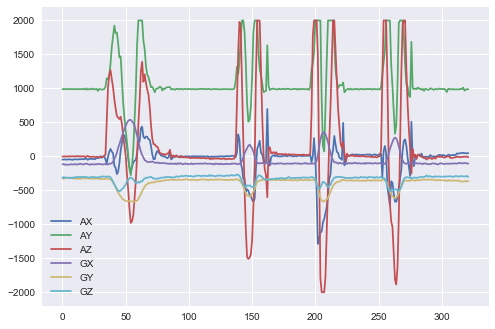

In [3]:
# Plot all variables
ex.iloc[:,1:].plot()

It seems that negative jumps in Accelerometer Y and Z axes will help us identify the swings. Let's examine them closer for swing #2.

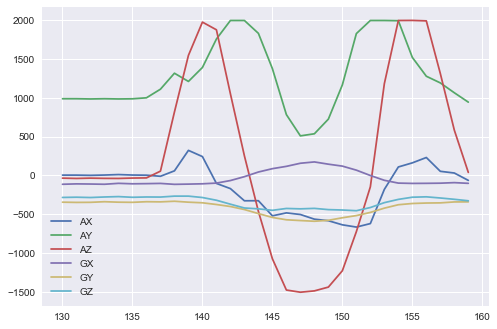

In [4]:
ex.iloc[130:160,1:].plot()

Now lets switch to real data. Probably the hardest to identify will be the closest putts (2 feet in our case). Let's load and examine a dataframe that contains exactly 30 putts for 2 feet (both successful and unsuccessful).

In [5]:
df = pd.read_csv("../DataCollect/data/Collected_Jul31/raw_20200731-004622.csv", index_col=0)
df.head()

,Time,AX,AY,AZ,GX,GY,GZ
0,21211,54,987,14,-89,-358,-330
1,21217,56,987,12,-85,-367,-318
2,21223,52,986,9,-77,-363,-337
3,21229,54,988,8,-92,-366,-328
4,21236,52,987,14,-94,-364,-325


Let's plot just accelerometer data for Z axis to see if we can count 30 putts.

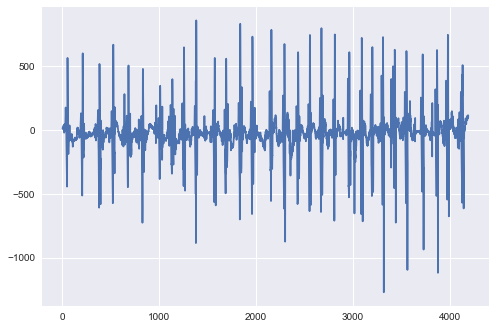

In [6]:
df.AZ.plot()

Looks promissing. Now let's look at most distant putts (6 feet). There are 30 of them the concern is whether we hit the top resolution for the axis (2000) too often.

In [7]:
df =  pd.read_csv("../DataCollect/data/Collected_Jul31/raw_20200731-020619.csv", index_col=0)
df.head()

,Time,AX,AY,AZ,GX,GY,GZ
0,24470,0,991,-11,-122,-358,-301
1,24476,0,988,-11,-115,-360,-307
2,24482,-9,988,-15,-109,-358,-303
3,24488,-1,983,-14,-113,-361,-304
4,24495,-10,987,-12,-116,-360,-303


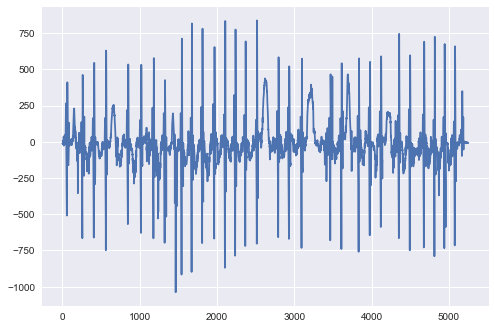

In [8]:
df.AZ.plot()

Looks like we are in the clear. However, one thing to observe is that there are putts that might have to speed-ups in acceleration. We check how many putts we can count if we set a threshold at -600

In [9]:
df.loc[df.AZ<=-600,].AZ.count()/2 # We devide by 2 because we intersect the threshold twice

27.0

Just setting a threshold is not enough. We will experiment with window sizes and combining several axes (Z and Y) to identify a putt.

# Putt identification with real data

Let's start with close putts.

In [10]:
df = pd.read_csv("../DataCollect/data/Collected_Jul31/raw_20200731-004622.csv", index_col=0)
df.head()

,Time,AX,AY,AZ,GX,GY,GZ
0,21211,54,987,14,-89,-358,-330
1,21217,56,987,12,-85,-367,-318
2,21223,52,986,9,-77,-363,-337
3,21229,54,988,8,-92,-366,-328
4,21236,52,987,14,-94,-364,-325


We isolate just a couple of putts. By analyzing putts in real time, I was able to isolate different parts of the swing.

Text(-10, 300, 'Putt forward')

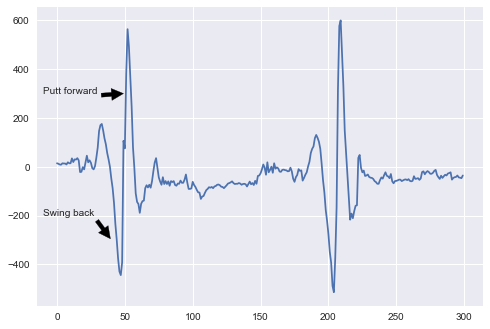

In [11]:
df.iloc[0:300,:].AZ.plot()
plt.annotate("Swing back", xy = (40,-300), xytext = (-10,-200), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate("Putt forward", xy = (50,300), xytext = (-10,300), arrowprops=dict(facecolor='black', shrink=0.05))

Let's do the same for AY axis.

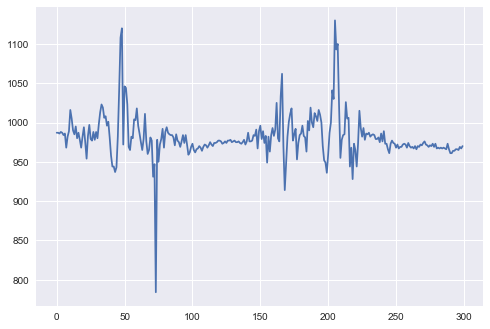

In [12]:
df.iloc[0:300,:].AY.plot()

And combining both.

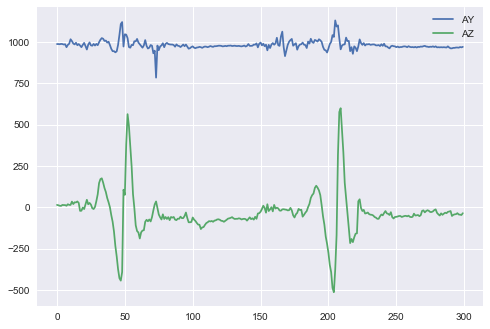

In [13]:
df.iloc[0:300].loc[:,["AY", "AZ"]].plot()

It seems like we can detect a putt by setting a band, looking for AZ to break through the band at least four times (2 for the lower and two for the upper band). And 50 observations seems to be an appropriate window to accomodate for the length of put. 

Let's try to come up with a function that will detect parts of a putt.

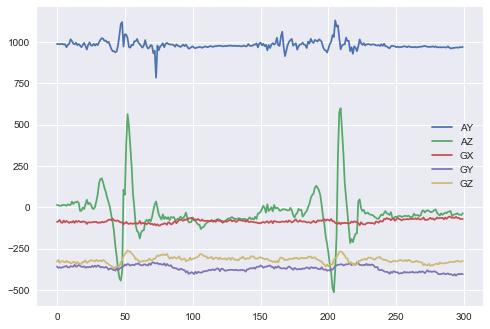

In [14]:
# Store observations to test on
test = df.iloc[0:300,:].copy()
test.iloc[:,2:].plot()

In [15]:
# Input arguments
lower_bound_AZ = -300 # For AZ
window = 50
margin = 25 # Left margin if we detected a first break through

In [16]:
def DetectPuttPoints(df, lower_bound_AZ, window=100, margin=25):
    '''
    Function to detect several parts of a putt - swing back, swing forward
    
    Returns a dataframe with orgignal data and marks: 1 - beginning of a swing back , 
    2 - beginnig of swing forward, 3 - end of swing forward
    
    '''
    
    df = df.set_index('Time')
    df['Mark'] = np.nan
    
    # Scan through the dataframe
    i = 0
    while i < (df.shape[0]-window):
        tmp = df.iloc[i:(i+window),:]

        
        # Found break through 
        if tmp.AZ.min()<lower_bound_AZ:
               
            # Step left by margin and find beginning of the swing
            mark_ind = tmp.loc[tmp.AZ == tmp.AZ.min(),:].index.values[0] # Find index of the min
            ind_num = df.index.get_loc(mark_ind)
            
            # Left part of the window
            tmp1 = df.iloc[(ind_num-margin):ind_num,:]
            mark_1_ind = tmp1.loc[tmp1.AZ == tmp1.AZ.max(),:].index.values[0]
      
            
            #  All window
            tmp2 = df.iloc[(ind_num-margin):(ind_num-margin+window),:]
            mark_3_ind = tmp2.loc[tmp2.AZ == tmp2.AZ.max(),:].index.values[0] # End of the swing forward
                        
            mark_2_ind = tmp2.loc[tmp2.AZ == tmp2.loc[mark_1_ind:mark_3_ind, 'AZ'].min(),:].index.values[0] # Beginning of the swing forward
            
            df.at[mark_1_ind, 'Mark'] = 1 # Mark beginning of swing backward
            df.at[mark_2_ind, 'Mark'] = 2 # Mark beginning of swing forward
            df.at[mark_3_ind, 'Mark'] = 3 # Mark end of swing forward
                                    
            # Reset i
            i = ind_num-margin+window
        
        else:
            i += 1
            continue # Continue scan
    
    
    
    return df
    

In [17]:
test1 = DetectPuttPoints(test, lower_bound_AZ,  window, margin)

Visualize

In [18]:
test1.loc[test1.Mark==1,:]

,AX,AY,AZ,GX,GY,GZ,Mark
Time,,,,,,,
21417,56,1023,175,-88,-361,-327,1.0
22404,70,1008,130,-92,-367,-313,1.0


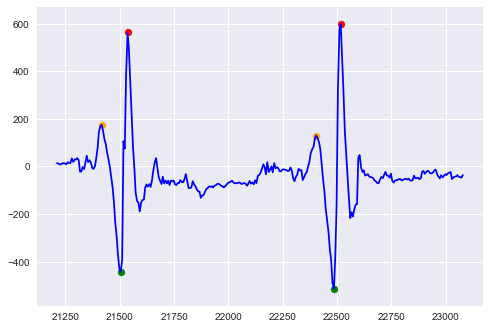

In [19]:
test1['StartBack'] = test1[['AZ','Mark']].apply(lambda x: x['AZ'] if x['Mark']==1 else np.nan, axis=1)
test1['StartFwd'] = test1[['AZ','Mark']].apply(lambda x: x['AZ'] if x['Mark']==2 else np.nan, axis=1)
test1['StopFwd'] = test1[['AZ','Mark']].apply(lambda x: x['AZ'] if x['Mark']==3 else np.nan, axis=1)

plt.plot(test1.AZ, color='blue')
plt.scatter(test1.index, test1.StartBack, color = 'orange')
plt.scatter(test1.index, test1.StartFwd, color = 'green')
plt.scatter(test1.index, test1.StopFwd, color = 'red')

Let's check if we can pick up all putts from a dataset of 30 short distance putts

In [20]:
putt = DetectPuttPoints(df, lower_bound_AZ, window, margin)

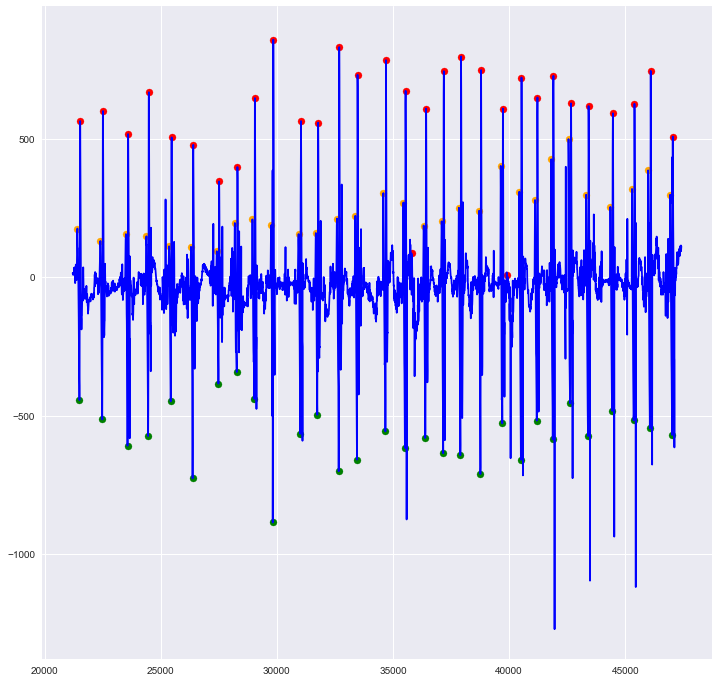

In [21]:
plt.figure(figsize=(12,12))
putt['StartBack'] = putt[['AZ','Mark']].apply(lambda x: x['AZ'] if x['Mark']==1 else np.nan, axis=1)
putt['StartFwd'] = putt[['AZ','Mark']].apply(lambda x: x['AZ'] if x['Mark']==2 else np.nan, axis=1)
putt['StopFwd'] = putt[['AZ','Mark']].apply(lambda x: x['AZ'] if x['Mark']==3 else np.nan, axis=1)

plt.plot(putt.AZ, color='blue')
plt.scatter(putt.index, putt.StartBack, color = 'orange')
plt.scatter(putt.index, putt.StartFwd, color = 'green')
plt.scatter(putt.index, putt.StopFwd, color = 'red')

In [22]:
putt.loc[~putt.Mark.isna(),:].groupby('Mark').count()

,AX,AY,AZ,GX,GY,GZ,StartBack,StartFwd,StopFwd
Mark,,,,,,,,,
1.0,30,30,30,30,30,30,30,0,0
2.0,30,30,30,30,30,30,0,30,0
3.0,32,32,32,32,32,32,0,0,32


Generally, we are doing ok, but we can see that some min/max may be doubled. See  observations indexed 44467, 45392

In [23]:
putt.loc[putt.Mark==3,:].tail()

,AX,AY,AZ,GX,GY,GZ,Mark,StartBack,StartFwd,StopFwd
Time,,,,,,,,,,
43417,87,1043,617,-98,-358,-267,3.0,NaN,NaN,617.0
44467,113,1044,591,-101,-346,-270,3.0,NaN,NaN,591.0
45392,109,1076,625,-104,-331,-270,3.0,NaN,NaN,625.0
46092,16,1004,744,-104,-355,-261,3.0,NaN,NaN,744.0
47042,108,1030,507,-94,-346,-258,3.0,NaN,NaN,507.0


But we can address it by making sure that the stages of a putt follow each other. Also, here we use AY variable with a threshold of 1100 to confirm that it was a real put (see Graphs below that show that with a putt there is a jump in AY value)

In [24]:
def MarkPutts(df, lower_bound_AZ, window, margin):
    '''
    The function return the dataframe with marked stages of a putt
    '''
    
    
    df = DetectPuttPoints(df, lower_bound_AZ, window, margin)
    df = df.reset_index()
    
    
    # Fill placeholder for the stage
    df['Stage'] = np.nan
    
    
    df.loc[df.Mark == 1, 'Stage'] = 'Back'
    df.loc[(df.Mark == 2) | (df.Mark == 3), 'Stage'] = 'Forward'
    
    # Get the first marked observation
    first_ind = df.Mark.first_valid_index()
    last_ind = df.Mark.last_valid_index()

    
    # Keep only relevant observations
    df = df.iloc[first_ind:(last_ind+1), :]

    
    # Find end of the putt
    for i in range(1,df.shape[0]):
        if (df.iloc[i-1, :]['Mark'] == 3) & (pd.isna(df.iloc[i, :]['Mark'])):
            
            df.iloc[i,df.columns.get_loc('Stage')] = 'Rest'
    

    
    df.Stage = df.Stage.ffill()  
    
    # Clean up weird observations
    
    df.Stage.loc[(df.Stage.shift()=='Rest') & (df.Stage.shift(-1)=='Rest') & (df.Stage!='Rest')] = 'Rest'
    
   
    
    return df
    
    

In [25]:
tt = MarkPutts(test, lower_bound_AZ, window, margin)
tt

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Time,AX,AY,AZ,GX,GY,GZ,Mark,Stage
33,21417,56,1023,175,-88,-361,-327,1.0,Back
34,21423,83,1019,149,-92,-363,-319,NaN,Back
35,21429,69,1006,116,-88,-366,-325,NaN,Back
36,21436,75,1008,92,-88,-361,-334,NaN,Back
37,21442,81,996,56,-82,-366,-339,NaN,Back
...,...,...,...,...,...,...,...,...,...
205,22492,50,1130,-376,-95,-357,-307,NaN,Forward
206,22498,99,1093,-168,-98,-352,-304,NaN,Forward
207,22504,81,1100,316,-100,-348,-286,NaN,Forward
208,22511,21,1022,576,-92,-348,-271,NaN,Forward


In [26]:
# Store observations to test on
test = df.iloc[0:300,:].copy()
test1 = MarkPutts(test, lower_bound_AZ,  window, margin)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Visualize

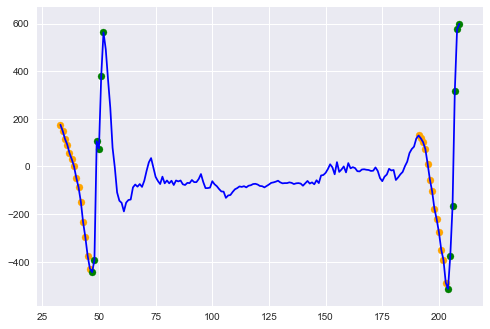

In [27]:
test1['GoBack'] = test1[['AZ','Stage']].apply(lambda x: x['AZ'] if x['Stage']=='Back' else np.nan, axis=1)
test1['GoFwd'] = test1[['AZ','Stage']].apply(lambda x: x['AZ'] if x['Stage']=='Forward' else np.nan, axis=1)

plt.plot(test1.AZ, color='blue')
plt.scatter(test1.index, test1.GoBack, color = 'orange')
plt.scatter(test1.index, test1.GoFwd, color = 'green')


We will try in for the whole dataset of 30 short putts.

In [28]:
putt = MarkPutts(df, lower_bound_AZ, window, margin)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


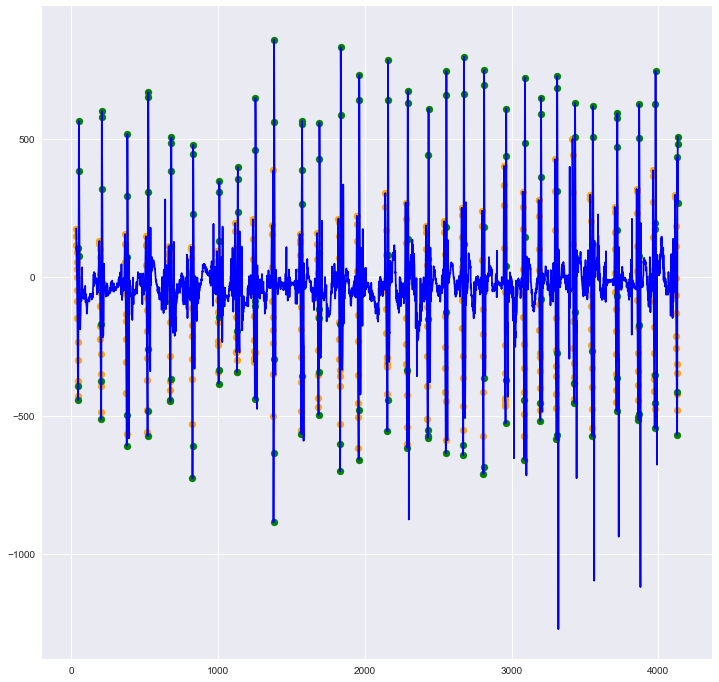

In [29]:
plt.figure(figsize=(12,12))
putt['GoBack'] = putt[['AZ','Stage']].apply(lambda x: x['AZ'] if x['Stage']=='Back' else np.nan, axis=1)
putt['GoFwd'] = putt[['AZ','Stage']].apply(lambda x: x['AZ'] if x['Stage']=='Forward' else np.nan, axis=1)

plt.plot(putt.AZ, color='blue')
plt.scatter(putt.index, putt.GoBack, color = 'orange')
plt.scatter(putt.index, putt.GoFwd, color = 'green')

Now, by removing rest periods we can separate observations into separate putts.

In [30]:
def SeparateDF(df, lower_bound_AZ, window, margin):
    '''
    We take the full data frame and create a disctionary with separate putts
    '''
    
    
    # Get stages
    df = MarkPutts(df, lower_bound_AZ, window, margin)
    
    pid = 1
    df['Id'] = pid 
    
    for i in range(1, df.shape[0]):
        
        if (df.iloc[i,:]['Stage'] == 'Back')|(df.iloc[i,:]['Stage'] == 'Forward'):
            df.iloc[i, df.columns.get_loc('Id')] = pid
        
        elif (df.iloc[i,:]['Stage'] == 'Rest') & (df.iloc[i-1,:]['Stage'] != 'Rest'):
            pid += 1 # Next move
            df.iloc[i, df.columns.get_loc('Id')] = np.nan
            
        else:
            df.iloc[i, df.columns.get_loc('Id')] = np.nan
    
    return df
    

In [31]:
putt_df = SeparateDF(df, lower_bound_AZ, window, margin)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [32]:
putt_df.tail()

,Time,AX,AY,AZ,GX,GY,GZ,Mark,Stage,Id
4129,47017,69,1188,-416,-101,-360,-330,NaN,Forward,30.0
4130,47023,253,1038,433,-97,-355,-297,NaN,Forward,30.0
4131,47029,29,1083,267,-100,-345,-280,NaN,Forward,30.0
4132,47036,79,1042,480,-89,-354,-273,NaN,Forward,30.0
4133,47042,108,1030,507,-94,-346,-258,3.0,Forward,30.0


# Collect all data

We collected data for the total of 250 putts. Let's see if we can correctly detect it. 

In [33]:
files = sorted(os.listdir("../DataCollect/data/Collected_Jul31/"))
files

['raw_20200731-004622.csv',
 'raw_20200731-005210.csv',
 'raw_20200731-005947.csv',
 'raw_20200731-010600.csv',
 'raw_20200731-011830.csv',
 'raw_20200731-013105.csv',
 'raw_20200731-014226.csv',
 'raw_20200731-015536.csv',
 'raw_20200731-020619.csv',
 'raw_20200731-021159.csv']

In [34]:
# Combine in a data frame
df = pd.DataFrame()

for i,f in enumerate(files):
    tmp = pd.read_csv("../DataCollect/data/Collected_Jul31/"+f, index_col=0)
    tmp.Time = i*100000 + tmp.Time # Add digits to avoid doubling Time values
    # Note file number and expected number of putts (we have 30 for odd and 20 for even)
    tmp['FileNum'] = i+1
    if (i+1)%2==0:
        tmp['ExpPutts'] = 20
    else:
        tmp['ExpPutts'] = 30
    
    df = df.append(tmp, ignore_index=True)

df.tail()
    

,Time,AX,AY,AZ,GX,GY,GZ,FileNum,ExpPutts
41352,934221,-93,985,6,-122,-31,-48,10,20
41353,934227,-93,984,4,-113,-34,-39,10,20
41354,934234,-93,985,4,-115,-25,-36,10,20
41355,934240,-94,986,5,-110,-28,-45,10,20
41356,934246,-93,983,4,-113,-33,-49,10,20


In [35]:
df.head()

,Time,AX,AY,AZ,GX,GY,GZ,FileNum,ExpPutts
0,21211,54,987,14,-89,-358,-330,1,30
1,21217,56,987,12,-85,-367,-318,1,30
2,21223,52,986,9,-77,-363,-337,1,30
3,21229,54,988,8,-92,-366,-328,1,30
4,21236,52,987,14,-94,-364,-325,1,30


In [36]:
df = SeparateDF(df, lower_bound_AZ, window, margin)
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Time,AX,AY,AZ,GX,GY,GZ,FileNum,ExpPutts,Mark,Stage,Id
33,21417,56,1023,175,-88,-361,-327,1,30,1.0,Back,1.0
34,21423,83,1019,149,-92,-363,-319,1,30,NaN,Back,1.0
35,21429,69,1006,116,-88,-366,-325,1,30,NaN,Back,1.0
36,21436,75,1008,92,-88,-361,-334,1,30,NaN,Back,1.0
37,21442,81,996,56,-82,-366,-339,1,30,NaN,Back,1.0


In [37]:
df.tail()

,Time,AX,AY,AZ,GX,GY,GZ,FileNum,ExpPutts,Mark,Stage,Id
41201,933277,-90,1106,-503,-88,-375,-336,10,20,NaN,Forward,260.0
41202,933284,14,1203,-187,-107,-367,-315,10,20,NaN,Forward,260.0
41203,933290,30,1094,245,-116,-357,-307,10,20,NaN,Forward,260.0
41204,933296,51,1021,500,-130,-348,-292,10,20,NaN,Forward,260.0
41205,933302,64,1043,536,-121,-346,-277,10,20,3.0,Forward,260.0


As we can see, there are 10 putts falsly detected.

In [38]:
# Let's examine which files are culprits
df.groupby(['FileNum'])['Id'].nunique()

FileNum
1     30
2     20
3     31
4     20
5     31
6     20
7     32
8     23
9     32
10    21
Name: Id, dtype: int64

By observation, we see that false detections usually coinside with very long string of stage observations. We can remove them automatically if the number of observations in one cycle is much larger than everage.

In [39]:
# Remove observations of resting stage
df = df.loc[df.Stage!='Rest']

# Check for very long or short stings and remove them
test = df.groupby("Id").Stage.count()
test = test.loc[(test>(np.mean(test) + 1.5*np.std(test))) | (test<((np.mean(test) - 1.5*np.std(test))))]

df_clean = df.loc[~df['Id'].isin(test.index.values),:]

In [40]:
# Let's examine again
df_clean.groupby(['FileNum'])['Id'].nunique()

FileNum
1     30
2     20
3     30
4     20
5     30
6     20
7     30
8     20
9     30
10    21
Name: Id, dtype: int64

Looks much cleaner. Now we have only one problem with the last file. We will exmine it separately.

In [41]:
files

['raw_20200731-004622.csv',
 'raw_20200731-005210.csv',
 'raw_20200731-005947.csv',
 'raw_20200731-010600.csv',
 'raw_20200731-011830.csv',
 'raw_20200731-013105.csv',
 'raw_20200731-014226.csv',
 'raw_20200731-015536.csv',
 'raw_20200731-020619.csv',
 'raw_20200731-021159.csv']

In [42]:
tt = pd.read_csv("../DataCollect/data/Collected_Jul31/"+files[-1], index_col = 0)
tt.head()

,Time,AX,AY,AZ,GX,GY,GZ
0,12727,0,995,-21,-116,-355,-301
1,12734,-1,985,-12,-118,-354,-304
2,12740,-5,979,-19,-113,-364,-309
3,12746,-2,982,-17,-107,-349,-309
4,12752,10,993,-9,-104,-366,-303


In [43]:
tt1 = SeparateDF(tt, lower_bound_AZ, window, margin)
tt1.tail()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Time,AX,AY,AZ,GX,GY,GZ,Mark,Stage,Id
3288,33277,-90,1106,-503,-88,-375,-336,NaN,Forward,21.0
3289,33284,14,1203,-187,-107,-367,-315,NaN,Forward,21.0
3290,33290,30,1094,245,-116,-357,-307,NaN,Forward,21.0
3291,33296,51,1021,500,-130,-348,-292,NaN,Forward,21.0
3292,33302,64,1043,536,-121,-346,-277,3.0,Forward,21.0


Let's highlight all assigned Ids

In [44]:
# Find peaks
assign_id = tt1.groupby('Id')['AZ'].max()
assign_id

Id
1.0      512
2.0      537
3.0      444
4.0      530
5.0      621
6.0      575
7.0      622
8.0       29
9.0      536
10.0     622
11.0     644
12.0     709
13.0     581
14.0     524
15.0     379
16.0     530
17.0     996
18.0    1218
19.0     550
20.0     435
21.0     536
Name: AZ, dtype: int64

It is clear that observation #8 is hardly a proper putt. So we need to set a minimum for the maximim value of AZ. 100 seems to be high enough. 

# Putting it all together and creating a cleaned dataset

In [45]:
# Input arguments
lower_bound_AZ = -300 # For AZ
upper_bound_AZ = 50 # to confirm the putt
window = 50
margin = 25 # Left margin if we detected a first break through

In [46]:
files = sorted(os.listdir("../DataCollect/data/Collected_Jul31/"))
files

['raw_20200731-004622.csv',
 'raw_20200731-005210.csv',
 'raw_20200731-005947.csv',
 'raw_20200731-010600.csv',
 'raw_20200731-011830.csv',
 'raw_20200731-013105.csv',
 'raw_20200731-014226.csv',
 'raw_20200731-015536.csv',
 'raw_20200731-020619.csv',
 'raw_20200731-021159.csv']

In [47]:
# Combine in a data frame
df = pd.DataFrame()

for i,f in enumerate(files):
    tmp = pd.read_csv("../DataCollect/data/Collected_Jul31/"+f, index_col=0)
    tmp.Time = i*100000 + tmp.Time # Add digits to avoid doubling Time values
    # Note file number and expected number of putts (we have 30 for odd and 20 for even)
    tmp['FileNum'] = i+1
    if (i+1)%2==0:
        tmp['ExpPutts'] = 20
    else:
        tmp['ExpPutts'] = 30
    
    df = df.append(tmp, ignore_index=True)

# Run identification
df = SeparateDF(df, lower_bound_AZ, window, margin)

# Remove observations of resting stage
df = df.loc[df.Stage!='Rest']

# Check for very long or short stings and remove them
test = df.groupby("Id").Stage.count()
test = test.loc[(test>(np.mean(test) + 1.5*np.std(test))) | (test<((np.mean(test) - 1.5*np.std(test))))]

df = df.loc[~df['Id'].isin(test.index.values),:]

# Set max threshold
test = df.groupby("Id").AZ.max()
test = test.loc[test < upper_bound_AZ]
df = df.loc[~df['Id'].isin(test.index.values),:]


# Reset Id
df['Id']=df.groupby('Id').ngroup().add(1)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [48]:
# Check number of putts per file
df.groupby(['FileNum'])['Id'].nunique()

FileNum
1     30
2     20
3     30
4     20
5     30
6     20
7     30
8     20
9     30
10    20
Name: Id, dtype: int64

In [49]:
df.tail()

,Time,AX,AY,AZ,GX,GY,GZ,FileNum,ExpPutts,Mark,Stage,Id
41201,933277,-90,1106,-503,-88,-375,-336,10,20,NaN,Forward,250
41202,933284,14,1203,-187,-107,-367,-315,10,20,NaN,Forward,250
41203,933290,30,1094,245,-116,-357,-307,10,20,NaN,Forward,250
41204,933296,51,1021,500,-130,-348,-292,10,20,NaN,Forward,250
41205,933302,64,1043,536,-121,-346,-277,10,20,3.0,Forward,250


Lets plot AZ axis to see if the data makes sense

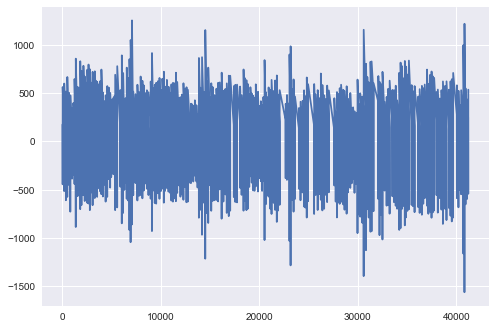

In [50]:
df.AZ.plot()

In [51]:
# Save data
df.to_csv("./data/df_clean.csv")

Just for fun, let's do an interactive cell for inspecting each putt

In [52]:
from ipywidgets import widgets
import warnings
warnings.filterwarnings('ignore')

def Plot(df,i = 1):

    tmp = df.loc[df.Id==i,:]
    tmp.loc[:,'StartBack'] = tmp[['AZ','Mark']].apply(lambda x: x['AZ'] if x['Mark']==1 else np.nan, axis=1)
    tmp.loc[:,'StartFwd'] = tmp[['AZ','Mark']].apply(lambda x: x['AZ'] if x['Mark']==2 else np.nan, axis=1)
    tmp.loc[:,'StopFwd'] = tmp[['AZ','Mark']].apply(lambda x: x['AZ'] if x['Mark']==3 else np.nan, axis=1)

    _ = plt.plot(tmp.AZ, color='blue')
    _ = plt.scatter(tmp.index, tmp.StartBack, color = 'orange')
    _ = plt.scatter(tmp.index, tmp.StartFwd, color = 'green')
    _ = plt.scatter(tmp.index, tmp.StopFwd, color = 'red')
    
    
    # Annotate
    x_sb = tmp.loc[tmp.Mark==1, :].index.values[0]
    y_sb = tmp.loc[tmp.Mark==1, :].StartBack.values[0]
    
    x_sf = tmp.loc[tmp.Mark==2, :].index.values[0]
    y_sf = tmp.loc[tmp.Mark==2, :].StartFwd.values[0]
    
    x_s = tmp.loc[tmp.Mark==3, :].index.values[0]
    y_s = tmp.loc[tmp.Mark==3, :].StopFwd.values[0]
    
    
    _ = plt.annotate('StartBack',xy=(x_sb, y_sb), color = 'orange', fontsize=12)
    _ = plt.annotate('Start Forward', xy=(x_sf, y_sf), color = 'green', fontsize=12)
    _ = plt.annotate('Stop', xy=(x_s, y_s), color = 'red', fontsize=12)
    
    
      
    _ = plt.title("Accelerometer Z")
    return plt.figure()


widgets.interact(Plot,
    df = widgets.fixed(df),
    i = widgets.Dropdown(
            options=df.Id.unique(),
            value=1.0,
            description='Putt id:',
            disabled=False,
        )
)


interactive(children=(Dropdown(description='Putt id:', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

<function __main__.Plot(df, i=1)>